## libs

In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import random
from scipy.interpolate import interp1d
from pathlib import Path
from scipy.optimize import curve_fit

## variables and constants

In [2]:
LOG_AGE = 8.38
DISTANCE = 250
RADIUS = 15
CORE = 3
POPULATION = 10000
ALPHA = 0.5
DISTRIBUTION_FUNCTION = 'flat'
PARAM = 2

In [3]:
STARS_DIRECTORY = Path('../../sessions/')
MAIN_DIRECTORY = Path('../../')
MODEL_DIRECTORY = Path('../../model/')

In [4]:
m1 = np.arange(0.07,0.08, 0.001)
m2 = np.geomspace(0.08,0.5, 50)
m3 = np.geomspace(0.5,30, num=50)

a1 = 0.8
a2 = 1.3
a3 = 2.3

## functions

In [5]:
def imf(mass, alpha):
    return np.power(mass,-alpha)

def neumann(data_1, data_2):
    """get q randomly from definite distribution"""
    iter = True
    while iter == True:
        x, yr = random()*data_1.max(), random()
        y = interp1d(data_1, data_2)
        if x >= data_1.min() and yr <= y(x):
            iter = False
            return x
        else:
            iter = True
            
def make_cluster (N, mf):
    """make model of cluster with N stars and IMF"""
    _arr = []
    for  i in range (0, N):
        _arr.append(neumann(mf['Mass'], mf['MF']))
    return pd.DataFrame(data = {'Mass' : _arr})

def interp (a, b, c): 
    """get mass of starS with definite magnitude"""
    func = interp1d(a, b)
    return func(c)

def func_q (function, *parameters):
    """reurn 2D array with q distribution"""
    x = np.linspace(0.0001,1,100)
    if function not in ['flat','power','gauss']:
        raise ValueError('function should be flat, power or gauss')
    
    if function == 'flat':
        return pd.DataFrame(data={'q': x, 'f': [1]*100})
    
    if function == 'power':
        return pd.DataFrame(data={'q': x, 'f': np.power(x, parameters)})


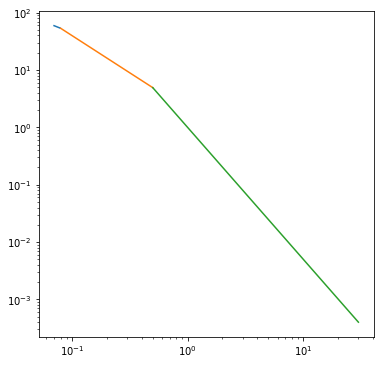

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(m1, imf(m1,a1)* imf(0.08,a2) / imf(0.08,a1) * imf(0.5,a3) / imf(0.5,a2))
ax.plot(m2, imf(m2,a2) * imf(0.5,a3) / imf(0.5,a2))
ax.plot(m3, imf(m3,a3))
plt.yscale('log')
plt.xscale('log')

In [7]:
masses = np.concatenate((m1,m2,m3))
imfunction = np.concatenate((imf(m1,a1)* imf(0.08,a2) / imf(0.08,a1) * imf(0.5,a3) / imf(0.5,a2),
                             imf(m2,a2) * imf(0.5,a3) / imf(0.5,a2),
                             imf(m3,a3)
                            ))
imf = pd.DataFrame(data={'Mass': masses, 'MF': imfunction})

In [8]:
isochrone = pd.read_csv(MODEL_DIRECTORY / (f'isochrone_model_{LOG_AGE}.txt'), delimiter='\\s+')

## masses modeling

In [9]:
imf = imf[(imf['Mass'] > isochrone['Mini'].min()) & (imf['Mass'] < isochrone['Mini'].max())]

singles = make_cluster(POPULATION - int(POPULATION * ALPHA), imf)
binaries = make_cluster(int(POPULATION * ALPHA), imf)

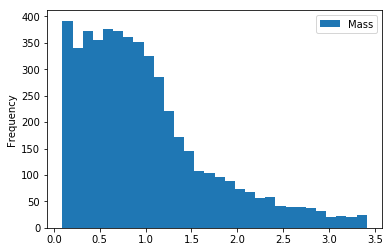

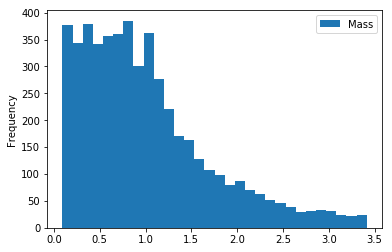

In [10]:
singles.plot.hist(bins=30)
binaries.plot.hist(bins=30)

In [11]:
distr_q = func_q(DISTRIBUTION_FUNCTION, PARAM)

In [12]:
binaries.columns=['Mass1']
binaries['Mass2'] = binaries['Mass1'] * np.fromiter((neumann(distr_q['q'], distr_q['f']) for x in range(len(binaries))), float)
binaries['Mass2'][binaries['Mass2'] < 0.09] = 0.09

## magnitudes modeling

In [13]:
singles['G, mag'] = interp(isochrone['Mini'], isochrone['Gmag'], singles['Mass'])
singles['BP, mag'] = interp(isochrone['Mini'], isochrone["G_BPmag"], singles['Mass']) 
singles['RP, mag'] = interp(isochrone['Mini'], isochrone["G_RPmag"], singles['Mass'])

In [14]:
binaries['G1, mag'] = interp(isochrone['Mini'], isochrone['Gmag'], binaries['Mass1'])
binaries['BP1, mag'] = interp(isochrone['Mini'], isochrone["G_BPmag"], binaries['Mass1']) 
binaries['RP1, mag'] = interp(isochrone['Mini'], isochrone["G_RPmag"], binaries['Mass1'])

binaries['G2, mag'] = interp(isochrone['Mini'], isochrone['Gmag'], binaries['Mass2'])
binaries['BP2, mag'] = interp(isochrone['Mini'], isochrone["G_BPmag"], binaries['Mass2']) 
binaries['RP2, mag'] = interp(isochrone['Mini'], isochrone["G_RPmag"], binaries['Mass2'])

In [15]:
binaries['G, mag'] = binaries['G2, mag'] - 2.5 *np.log10(1+ pow(2.512, binaries['G2, mag'] - binaries['G1, mag']))
binaries['BP-RP, mag'] = (binaries['BP2, mag'] -
                          2.5 *np.log10(1+ pow(2.512, binaries['BP2, mag'] - binaries['BP1, mag'])) -
                          (binaries['RP2, mag'] - 2.5 *np.log10(1+ pow(2.512, binaries['RP2, mag'] - 
                           binaries['RP1, mag']))))
singles['BP-RP, mag'] = singles['BP, mag'] - singles['RP, mag']

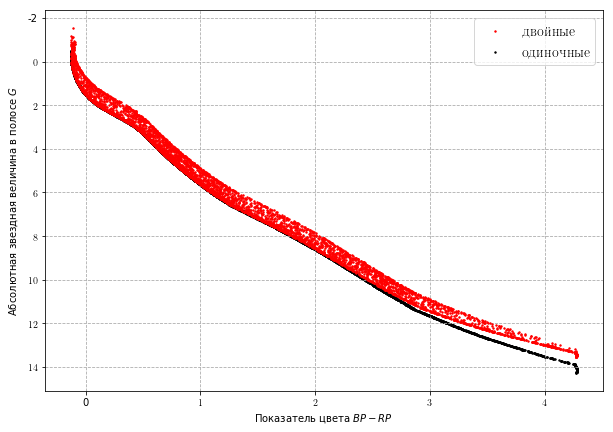

In [16]:
fig, ax = plt.subplots(figsize=(10,7))

plt.rcParams.update({'font.size': 25})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

ax.scatter (binaries['BP-RP, mag'],
            binaries['G, mag'],
            c='red', s=2, label='двойные', zorder=100)
ax.scatter (singles['BP-RP, mag'],
            singles['G, mag'],
            c='black', s=2, label='одиночные', zorder=1)

ax.invert_yaxis()
ax.grid(c='#aaaaaa', ls='--')

plt.xlabel('Показатель цвета $BP-RP$')
plt.ylabel('Абсолютная звездная величина в полосе $G$', labelpad=8)

#plt.yticks(np.arange(6,19, step=1.0))
#plt.xticks(np.arange(-0.5, 3, step=0.5))

ax.tick_params(axis='both', which='major')

ax.legend(loc='upper right')
#plt.savefig(MODEL_DIRECTORY / (f"model_{LOG_AGE}.pdf"), bbox_inches = 'tight')


## observing changes

In [17]:
singles['distance'] = np.random.normal(loc=DISTANCE, scale=CORE, size=len(singles['G, mag']))
binaries['distance'] = np.random.normal(loc=DISTANCE, scale=CORE, size=len(binaries['G, mag']))

In [18]:
singles['g, mag'] = singles['G, mag'] + 5 * np.log10(singles['distance']) - 5
binaries['g, mag'] = binaries['G, mag'] + 5 * np.log10(binaries['distance']) - 5

In [19]:
real_cluster = pd.read_csv(Path('../sessions/') / ('NGC_2437_selected'), delimiter='\\s+')

In [20]:
real_cluster['phot_errors'] = 1.086 * real_cluster['phot_bp_mean_flux_error'] / real_cluster['phot_bp_mean_flux']

def get_errors (data, data_out):
    data['err_bin'] = pd.cut(bins=np.linspace(0, data['phot_g_mean_mag'].max(), 100), x=data['phot_g_mean_mag'])  # splitting interval
    intervals = data.groupby('err_bin').apply(lambda df: df['phot_errors'].quantile(0.68))
    intervals.index = intervals.index.map(lambda x: x.mid)
    intervals.dropna(inplace=True)
    
    popt, pcov = curve_fit(f, np.array(intervals.index.tolist()), np.array(intervals.tolist()))
    #return pd.DataFrame(data = {err_name : f(data['G, mag'], *popt)})
    return np.array(f(data_out, *popt))

def f(x, a, b):
    return np.exp(x) * a + b

phot_errors_binaries = get_errors(real_cluster, binaries['g, mag'])
phot_errors_singles = get_errors(real_cluster, singles['g, mag'])

In [21]:
singles['g, mag'] += np.random.normal(loc=0.0, scale=phot_errors_singles, size=len(singles['G, mag']))
binaries['g, mag'] += np.random.normal(loc=0.0, scale=phot_errors_binaries, size=len(binaries['G, mag']))

singles['bp-rp, mag'] = singles['BP-RP, mag'] + np.random.normal(loc=0.0, scale=phot_errors_singles*m.pow(2,0.5), size=len(singles['G, mag']))
binaries['bp-rp, mag'] = binaries['BP-RP, mag'] + np.random.normal(loc=0.0, scale=phot_errors_binaries*m.pow(2,0.5), size=len(binaries['G, mag']))

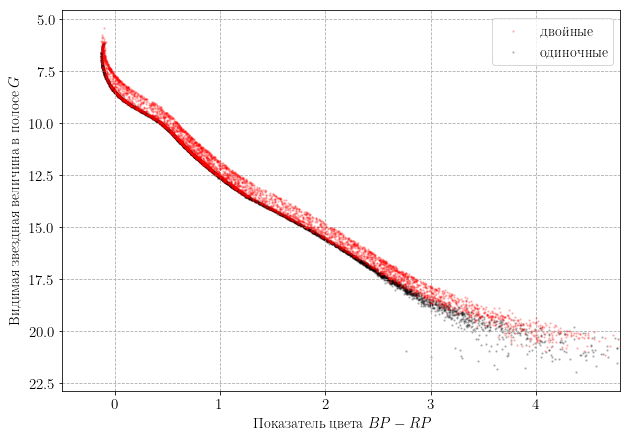

In [26]:
fig, ax = plt.subplots(figsize=(10,7))

plt.rcParams.update({'font.size': 25})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

ax.scatter (binaries['bp-rp, mag'],
            binaries['g, mag'],
            c='red', s=2, label='двойные', zorder=100, alpha=0.2)
ax.scatter (singles['bp-rp, mag'],
            singles['g, mag'],
            c='black', s=2, label='одиночные', zorder=1, alpha=0.2)

ax.invert_yaxis()
ax.grid(c='#aaaaaa', ls='--')

plt.xlabel('Показатель цвета $BP-RP$')
plt.ylabel('Видимая звездная величина в полосе $G$', labelpad=8)

ax.set_xlim(-0.5,4.8)
ax.tick_params(axis='both', which='major')

ax.legend(loc='upper right')
#plt.savefig(MODEL_DIRECTORY / (f"model_{LOG_AGE}_with_errors.pdf"), bbox_inches = 'tight')

In [23]:
model = pd.concat([binaries, singles], sort=False)

model = model[(model['bp-rp, mag']>-0.3)]
model = model[(model['bp-rp, mag']<2.4) & (model['g, mag'] < 18.5)]

In [24]:
model.to_csv(MODEL_DIRECTORY  / f'model_stars_{DISTANCE}pc_manystars_{DISTRIBUTION_FUNCTION}{PARAM}.txt', sep=' ', index=False, na_rep='Nan')